   ## Principal component analysis (PCA)

In [1]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

from pyspark import SparkContext
from pyspark.sql import SQLContext

In [2]:
# stop active context and start a new instance
sca = SparkContext._active_spark_context
if sca:
    sca.stop()
sc = SparkContext()


### Loading the dataset

In [3]:
# load the bike buyer dataset, skip header line
bbFileLocation = 'file:/datasets/BikeBuyerWithLocation.csv'
bbData = sc.textFile(bbFileLocation)
bbHeader = bbData.first()
bbData = bbData.filter(lambda x: x != bbHeader)
print "Data size is {}".format(bbData.count())
bbData.take(2)

Data size is 10000


[u'29476,Married,Female,20000,0,Partial College,Manual,No,1,0-1 Miles,Europe,47,Yes,31.42728,151.40989,Skegness,U8H 3NI,United Kingdom',
 u'29472,Married,Female,10000,1,High School,Manual,No,1,1-2 Miles,Europe,46,No,-49.777,-57.09436,Krefeld,38010,Germany']

### Preparing the dataset

In [4]:
# Prepare the dataset
# Convert label to 0/1 (as double)
def convertYesNo(strlabel):
    lbl = 0.0
    if (strlabel == 'Yes'):
        lbl = 1.0
    return lbl

# Country not specified for regions North America / Pacific
# In these cases we use the region instead, since empty names are not allowed
def convertCountry(strCountry, strRegion):
    strCountryOut = strCountry
    if (strCountry == ""):
        strCountryOut = strRegion    
    return strCountryOut

# Parse data and create data frames
from pyspark.sql import Row

parts = bbData.map(lambda l: l.split(",", -1))
# select relevant columns for further processing
features = parts.map(lambda p: (convertYesNo(p[12]),p[1],p[2],p[3],p[4],p[5],p[6],
                                p[7], p[8], p[9], p[10],p[11],
                                convertCountry(p[17], p[10])))
featuresRows = features.map(lambda p: Row(label=p[0], MaritalStatus=p[1], Gender=p[2],
                                         YearlyIncome=p[3], Children=p[4], Education=p[5],
                                         Occupation=p[6], HomeOwner=p[7], Cars=p[8],
                                         CommuteDistance=p[9], Region=p[10], Age=p[11],
                                         Country=p[12]))

# sc is an existing spark context
sqlContext = SQLContext(sc)

# Register the DataFrame as a table
dfBB = sqlContext.createDataFrame(featuresRows)
dfBB.registerTempTable("bikebuyers")
dfBB.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Cars: string (nullable = true)
 |-- Children: string (nullable = true)
 |-- CommuteDistance: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HomeOwner: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- YearlyIncome: string (nullable = true)
 |-- label: double (nullable = true)



#### Cast numeric features to double
In addition to casting to double, we "normalize" the values so that these are roughly of the same order of magnitude.

In [5]:
dfBB = dfBB.withColumn("IntAgeTmp", dfBB.Age.cast('double') / 100.0 ) \
            .drop("Age") \
            .withColumnRenamed("IntAgeTmp", "Age")
dfBB = dfBB.withColumn("IntCarsTmp", dfBB.Cars.cast('double')) \
            .drop("Cars") \
            .withColumnRenamed("IntCarsTmp", "Cars")
dfBB = dfBB.withColumn("IntChildrenTmp", dfBB.Children.cast('double')) \
            .drop("Children") \
            .withColumnRenamed("IntChildrenTmp", "Children")
dfBB = dfBB.withColumn("IntYearlyIncomeTmp", dfBB.YearlyIncome.cast('double') / 100000.0) \
            .drop("YearlyIncome") \
            .withColumnRenamed("IntYearlyIncomeTmp", "YearlyIncome")     


#### One-hot encoding: convert categorical features to numerical ones

In [6]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
MaritalStatusIndexer = StringIndexer(inputCol="MaritalStatus", outputCol="indMaritalStatus")
MaritalStatusEncoder = OneHotEncoder(inputCol="indMaritalStatus", outputCol="vecMaritalStatus")
GenderIndexer = StringIndexer(inputCol="Gender", outputCol="indGender")
GenderEncoder = OneHotEncoder(inputCol="indGender", outputCol="vecGender")
HomeOwnerIndexer = StringIndexer(inputCol="HomeOwner", outputCol="indHomeOwner")
HomeOwnerEncoder = OneHotEncoder(inputCol="indHomeOwner", outputCol="vecHomeOwner")
EducationIndexer = StringIndexer(inputCol="Education", outputCol="indEducation")
EducationEncoder = OneHotEncoder(inputCol="indEducation", outputCol="vecEducation")
OccupationIndexer = StringIndexer(inputCol="Occupation", outputCol="indOccupation")
OccupationEncoder = OneHotEncoder(inputCol="indOccupation", outputCol="vecOccupation")
CommuteDistanceIndexer = StringIndexer(inputCol="CommuteDistance", 
                                       outputCol="indCommuteDistance")
CommuteDistanceEncoder = OneHotEncoder(inputCol="indCommuteDistance", 
                                       outputCol="vecCommuteDistance")
RegionIndexer = StringIndexer(inputCol="Region", outputCol="indRegion")
RegionEncoder = OneHotEncoder(inputCol="indRegion", outputCol="vecRegion")
CountryIndexer = StringIndexer(inputCol="Country", outputCol="indCountry")
CountryEncoder = OneHotEncoder(inputCol="indCountry", outputCol="vecCountry")


In [7]:
# set up a pipeline for one-hot-encoding
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
featureAssembler = VectorAssembler(inputCols=["Age","Children","Cars","YearlyIncome",
                                            "vecMaritalStatus","vecGender",
                                            "vecHomeOwner", "vecEducation",
                                            "vecOccupation","vecCommuteDistance", "vecRegion",
                                            "vecCountry"],
                                  outputCol="features")
pipelineOHE = Pipeline(stages=[MaritalStatusIndexer, MaritalStatusEncoder, 
                               GenderIndexer, GenderEncoder, 
                               HomeOwnerIndexer, HomeOwnerEncoder,
                               EducationIndexer, EducationEncoder,
                               OccupationIndexer, OccupationEncoder,
                               CommuteDistanceIndexer, CommuteDistanceEncoder,
                               RegionIndexer, RegionEncoder, CountryIndexer, CountryEncoder,
                                featureAssembler])
modelOHE = pipelineOHE.fit(dfBB)
featuresOHE = modelOHE.transform(dfBB).select("features")


Now let's have a look at the transformed features.

In [8]:
print featuresOHE.take(4)

[Row(features=SparseVector(25, {0: 0.47, 2: 1.0, 3: 0.2, 4: 1.0, 7: 1.0, 15: 1.0, 20: 1.0, 23: 1.0})), Row(features=SparseVector(25, {0: 0.46, 1: 1.0, 2: 1.0, 3: 0.1, 4: 1.0, 9: 1.0, 17: 1.0, 20: 1.0})), Row(features=SparseVector(25, {0: 0.46, 1: 1.0, 2: 1.0, 3: 0.1, 9: 1.0, 20: 1.0, 23: 1.0})), Row(features=SparseVector(25, {0: 0.46, 1: 1.0, 2: 1.0, 3: 0.1, 5: 1.0, 9: 1.0, 17: 1.0, 20: 1.0, 24: 1.0}))]


### Principal Component Analysis (PCA)
We are now ready to apply the PCA module to the one-hot encoded features.

In [9]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(featuresOHE)
pcaFeatures = model.transform(featuresOHE).select("pcaFeatures")
pcaFeatures.show(truncate=False)

+----------------------------------------------------------------+
|pcaFeatures                                                     |
+----------------------------------------------------------------+
|[-0.4776710026574896,0.36828336194345207,-0.7420444677421998]   |
|[-1.3347146739959386,0.37085602920566085,-0.30369517158815235]  |
|[-1.3295979662870574,0.2960707511380036,-0.6287981352970808]    |
|[-1.3007056900294824,0.34770731248921544,-0.5770297566584514]   |
|[-0.44268600306292566,0.587057933615011,-0.7425495435388914]    |
|[-0.43589483360964065,0.5893665393654044,-0.855231647751818]    |
|[0.053810214695810266,-0.47106282115230314,-0.5036676267147404] |
|[-0.45476764527073044,0.33631896596997596,-0.8655138053162288]  |
|[-0.0912509629644341,-0.5023777179048213,-0.524090976343889]    |
|[-0.04941938150312039,-0.4877605989627288,-0.556145543650985]   |
|[-0.0663146913704673,-0.42891631013508896,-0.55914978687265]    |
|[-0.017888686679770244,-0.5492416731880664,-0.241241194297708

#### Extract eigenvectors
[desertnau at stackoverflow:](http://stackoverflow.com/questions/33428589/pyspark-and-pca-how-can-i-extract-the-eigenvectors-of-this-pca-how-can-i-calcu/)
"Well, it seems incredible, but indeed there is not a way to extract such information from a PCA decomposition (at least as of Spark 1.5). "
We grab the code provided by desertnaut:

In [10]:
import numpy as np

def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

In [11]:
from numpy.linalg import eigh

def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

Before we can apply these functions, we have to convert the sparse vectors to arrays.

In [12]:
featuresDense = featuresOHE.map(lambda sv: (Vectors.dense((sv[0]).toArray()),))
dfFeatures = sqlContext.createDataFrame(featuresDense,["features"])

comp, score, eigVals = pca(dfFeatures,3)
score.take(5)

[array([ 0.477671  ,  0.36828336,  0.74204447]),
 array([ 1.33471467,  0.37085603,  0.30369517]),
 array([ 1.32959797,  0.29607075,  0.62879814]),
 array([ 1.30070569,  0.34770731,  0.57702976]),
 array([ 0.442686  ,  0.58705793,  0.74254954])]

#### Explained variance ratio
We would like to know how well the first k principal components capture the variance in the dataset.

In [13]:
def varianceExplained(df, k=1):
     """Calculate the fraction of variance explained by the top `k` eigenvectors.

     Args:
         df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
         k: The number of principal components to consider.

     Returns:
         float: A number between 0 and 1 representing the percentage of variance explained
             by the top `k` eigenvectors.
     """
     components, scores, eigenvalues = pca(df, k)  
     return sum(eigenvalues[0:k])/sum(eigenvalues)

In [14]:
print varianceExplained(dfFeatures, 3)

0.619530151197


#### The first three principal components

In [15]:
print comp

[[  2.80699384e-03   1.90927045e-02  -7.30590334e-03]
 [  8.87433043e-01  -4.05069274e-01  -1.43196938e-01]
 [  4.17598020e-01   8.28210622e-01   1.95253888e-01]
 [  1.01391938e-01   7.33642703e-02  -1.09044570e-01]
 [  3.85958369e-02  -2.34984435e-02  -1.34124451e-01]
 [ -9.57410680e-04   9.99630490e-04  -4.69768892e-03]
 [  3.30749945e-02  -5.48713355e-02  -1.28228923e-01]
 [  8.04012342e-03  -5.22189580e-02   8.88843874e-03]
 [  3.08712086e-02   1.63107537e-02   9.21840852e-03]
 [  7.06689165e-03   6.62994504e-02   3.23212166e-02]
 [ -3.75082028e-02  -8.20185332e-02  -1.28262369e-01]
 [  6.82877202e-02   3.34921688e-02  -9.30138727e-02]
 [ -5.28568992e-02   8.52999268e-03  -1.66873211e-01]
 [  4.66476219e-02   9.59266447e-02  -5.24331230e-02]
 [ -3.06919451e-02  -6.59851837e-02   1.07946682e-01]
 [ -1.42302528e-02  -1.98367165e-01   1.38584139e-01]
 [ -6.59429963e-03   9.57276812e-02  -6.54784480e-02]
 [ -3.38145010e-02   4.13333621e-02  -4.45425343e-02]
 [  5.93066185e-02   9.50748

In the first vector, the feature "Children" is dominant, in the second vector it is the feature "Cars" and in the third vector it's the feature "North America".

#### Visualization

In [16]:
s0 = score.map(lambda x: x[0])
s1 = score.map(lambda x: x[1])
s2 = score.map(lambda x: x[2])

In [17]:
import numpy as np
import matplotlib.pyplot as plt

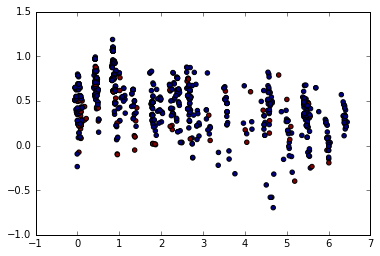

In [18]:
%matplotlib inline
N = 1000
s0a = s0.take(N)
s1a = s1.take(N)
s2a = s2.take(N)
lbl = dfBB.map(lambda x: x.label).take(N)
plt.scatter(s0a, s2a, c=lbl)
plt.show()